In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import scipy.stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import urllib
import requests
import zipfile
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
from sklearn.decomposition import PCA
import geopandas as gpd

Populating the interactive namespace from numpy and matplotlib


C:\Users\sddz0\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### I'm going to address the following questions:
### What are the social/community impacts of building energy use and emissions?       Specifically, 
- What is the relationship between building energy use and public health, measured by the local asthma hospitalization rate?
- What is the relationship between neighborhood income and residential building energy use?

### Download files

## As the Department of Health has only released asthma discharge data for 2012 - 2014 most recently so all the data I would use would be on that time period level

### 1. asthma 

In [2]:
def get_asthma(url):
    data = pd.read_html(url)[0][2:]
    return data

In [3]:
counties = ["new_y", "queen", "kings", "bronx", "richm"]
asthma = pd.concat(get_asthma('https://www.health.ny.gov/statistics/ny_asthma/hosp/zipcode/{}_t6.htm'.format(counties)) 
                   for counties in counties)
asthma.columns = ["Zip Code", "Discharges 2012_2014", "Discharge Rate"]
asthma.reset_index(inplace=True)
asthma = asthma.drop("index", axis=1)
asthma['Zip Code'] = asthma['Zip Code'].str[:5]

In [4]:
asthma['Discharge Rate'] = pd.to_numeric(asthma['Discharge Rate'],errors='coerce')
asthma['Discharges 2012_2014'] = pd.to_numeric(asthma['Discharges 2012_2014'],errors='coerce')

In [5]:
asthma.dropna(axis=0,inplace=True)

In [6]:
asthma.head()

,Zip Code,Discharges 2012_2014,Discharge Rate
0,10001,159.0,21.9
1,10002,592.0,23.9
2,10003,130.0,7.7
4,10005,6.0,2.2
6,10007,14.0,2.9


### removing outliers

In [7]:
def clean(df,column):
    """Filters out
    examples that fall outside the threshold of two standard deviations.
    
    Returns outlier-free dataframe."""
    
    df = df[(df[column]<np.mean(df[column])+2*np.std(df[column]))&(df[column]>np.mean(df[column])-2*np.std(df[column]))]
    return df

In [8]:
asthma = clean(asthma,'Discharge Rate')

In [9]:
asthma.describe()

,Discharges 2012_2014,Discharge Rate
count,163.000000,163.000000
mean,331.693252,21.258282
std,334.667945,14.137036
min,0.000000,0.000000
25%,105.500000,10.750000
50%,221.000000,17.700000
75%,412.000000,28.300000
max,1567.000000,60.500000


### 2. LL84

### As there are differences between Source and Site EUI which both have their own merits, but Site EUI is more practical here because we are analyzing its effect on public health so we don't want to consider the primary energy use. So I would be using Site EUI to do my analytics. 

In [10]:
def get_EU(url):
    data = pd.read_excel(url)
    cols = data.columns.str.replace('\xc2\xb2', '_2')
    data.columns = cols
    data.rename(columns = {'Site EUI\n(kBtu/ft2)':'Site EUI',
                               'Property Floor Area (Buildngs and Parking)\n(ft2)':'Reported Building Square Footage',
                               'DOF Property Floor Area (Buildngs and Parking)\n(ft2)':'Reported Building Square Footage',
                              'Weather Normalized Source EUI\n(kBtu/ft2)':'Weather Normalized Source EUI',
                               'Zip Code':'Zip','DOF Number of Buildings':'Number of Buildings',
                              'Total GHG Emissions\n(MtCO2e)':'GHG',
                          'Primary Property Type - Self Selected':'Reported Facility Type'},inplace=True)
    
    # select only residential buildings
    data = data[(data['Reported Facility Type'] == 'Residence Hall/Dormitory')|(data['Reported Facility Type'] == 'Multifamily Housing')|
           (data['Reported Facility Type'] == 'Lodging')|(data['Reported Facility Type'] == 'Other - Lodging/Residential')]
    
    data['Site EU'] = pd.to_numeric(data['Site EUI'],errors= 'coerce') * pd.to_numeric(
        data['Reported Building Square Footage'],errors= 'coerce')
    data['Source EU'] = pd.to_numeric(data['Weather Normalized Source EUI'],errors= 'coerce') * pd.to_numeric(
        data['Reported Building Square Footage'],errors= 'coerce')
    data['GHG'] = pd.to_numeric(data['GHG'],errors= 'coerce')
    data['Zip'] = data['Zip'].astype('str')
    data['Zip'] = data['Zip'].str[:5]
    data = data.groupby('Zip').sum()[['Site EU','Source EU','Reported Building Square Footage','Number of Buildings','GHG']]
    return data

In [11]:
energy_12 = get_EU('http://www.nyc.gov/html/gbee/downloads/excel/2012_nyc_cy2011_ll84_disclosure_data.xls')
energy_13 = get_EU('http://www.nyc.gov/html/gbee/downloads/excel/2013_nyc_ll84_disclosure.xlsx')
energy_14 = get_EU('http://www.nyc.gov/html/gbee/downloads/excel/150428_2014_nyc_ll84_disclosure.xlsx')

In [12]:
EU = (energy_12+energy_13+energy_14)

In [13]:
EU.dropna(axis=0 ,inplace=True)

In [14]:
EU['Site EUI'] = EU['Site EU'] / EU['Reported Building Square Footage']
EU['Source EUI'] = EU['Source EU'] / EU['Reported Building Square Footage']
EU = EU[['Site EUI','Source EUI','Number of Buildings','GHG']]
EU.reset_index(inplace=True)

### removing outliers

In [15]:
EU = clean(EU,'Site EUI')

In [16]:
EU.describe()

,Site EUI,Source EUI,Number of Buildings,GHG
count,78.000000,78.000000,78.000000,7.800000e+01
mean,350.153611,466.009315,232.589744,1.237591e+06
std,919.273032,1222.721321,359.630057,3.938836e+06
min,9.600471,20.133530,14.000000,3.979810e+03
25%,54.687197,82.421204,86.500000,3.251291e+04
50%,72.925067,109.239443,167.000000,8.494854e+04
75%,87.692190,144.423224,298.500000,1.738132e+05
max,6261.962526,8740.918820,3111.000000,2.973371e+07


### 3. PLUTO

In [17]:
for br in ['bx','bk','mn','qn','si']:
    urllib.urlretrieve('https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/{}_mappluto_16v2.zip'.format(br),
                       '{}.zip'.format(br))
    file = zipfile.ZipFile('{}.zip'.format(br))
    file.extractall()

In [79]:
urllib.urlretrieve('https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip'
                  ,'nyc_zip.zip')
file = zipfile.ZipFile('nyc_zip.zip')
file.extractall()

In [80]:
!dir

 驱动器 C 中的卷是 Windows
 卷的序列号是 D0FF-25F2

 C:\Users\sddz0\CIVIC\Problem Set 2 的目录

2017/11/13  01:46    <DIR>          .
2017/11/13  01:46    <DIR>          ..
2017/11/11  15:02    <DIR>          .ipynb_checkpoints
2017/11/13  01:40        52,948,965 bk.zip
2017/11/13  01:40         3,420,160 BKMapPLUTO.BBL.atx
2017/11/13  01:40         2,254,848 BKMapPLUTO.CD.atx
2017/11/13  01:40       223,468,381 BKMapPLUTO.dbf
2017/11/13  01:40         2,254,848 BKMapPLUTO.LandUse.atx
2017/11/13  01:40               562 BKMapPLUTO.prj
2017/11/13  01:40            29,148 BKMapPLUTO.sbn
2017/11/13  01:40             1,172 BKMapPLUTO.sbx
2017/11/13  01:40        42,720,184 BKMapPLUTO.shp
2017/11/13  01:40           154,526 BKMapPLUTO.shp.xml
2017/11/13  01:40         2,215,372 BKMapPLUTO.shx
2017/11/13  01:40         4,577,280 BKMapPLUTO.ZoneDist1.atx
2017/11/13  01:40            12,152 BK_Dcp_Mappinglot.dbf
2017/11/13  01:40               562 BK_Dcp_Mappinglot.prj
2017/11/13  01:40               788 BK_

### 4. CENSUS

### I'm now using demographic data from NYC OpenData

In [19]:
cv = pd.read_csv('https://data.cityofnewyork.us/api/views/kku6-nxdu/rows.csv?accessType=DOWNLOAD')

In [20]:
cv.head()

,JURISDICTION NAME,COUNT PARTICIPANTS,COUNT FEMALE,PERCENT FEMALE,COUNT MALE,PERCENT MALE,COUNT GENDER UNKNOWN,PERCENT GENDER UNKNOWN,COUNT GENDER TOTAL,PERCENT GENDER TOTAL,COUNT PACIFIC ISLANDER,PERCENT PACIFIC ISLANDER,COUNT HISPANIC LATINO,PERCENT HISPANIC LATINO,COUNT AMERICAN INDIAN,PERCENT AMERICAN INDIAN,COUNT ASIAN NON HISPANIC,PERCENT ASIAN NON HISPANIC,COUNT WHITE NON HISPANIC,PERCENT WHITE NON HISPANIC,COUNT BLACK NON HISPANIC,PERCENT BLACK NON HISPANIC,COUNT OTHER ETHNICITY,PERCENT OTHER ETHNICITY,COUNT ETHNICITY UNKNOWN,PERCENT ETHNICITY UNKNOWN,COUNT ETHNICITY TOTAL,PERCENT ETHNICITY TOTAL,COUNT PERMANENT RESIDENT ALIEN,PERCENT PERMANENT RESIDENT ALIEN,COUNT US CITIZEN,PERCENT US CITIZEN,COUNT OTHER CITIZEN STATUS,PERCENT OTHER CITIZEN STATUS,COUNT CITIZEN STATUS UNKNOWN,PERCENT CITIZEN STATUS UNKNOWN,COUNT CITIZEN STATUS TOTAL,PERCENT CITIZEN STATUS TOTAL,COUNT RECEIVES PUBLIC ASSISTANCE,PERCENT RECEIVES PUBLIC ASSISTANCE,COUNT NRECEIVES PUBLIC ASSISTANCE,PERCENT NRECEIVES PUBLIC ASSISTANCE,COUNT PUBLIC ASSISTANCE UNKNOWN,PERCENT PUBLIC ASSISTANCE UNKNOWN,COUNT PUBLIC ASSISTANCE TOTAL,PERCENT PUBLIC ASSISTANCE TOTAL
0,10001,44,22,0.50,22,0.50,0,0,44,100,0,0.0,16,0.36,0,0.0,3,0.07,1,0.02,21,0.48,3,0.07,0,0.0,44,100,2,0.05,42,0.95,0,0.0,0,0,44,100,20,0.45,24,0.55,0,0,44,100
1,10002,35,19,0.54,16,0.46,0,0,35,100,0,0.0,1,0.03,0,0.0,28,0.80,6,0.17,0,0.00,0,0.00,0,0.0,35,100,2,0.06,33,0.94,0,0.0,0,0,35,100,2,0.06,33,0.94,0,0,35,100
2,10003,1,1,1.00,0,0.00,0,0,1,100,0,0.0,0,0.00,0,0.0,1,1.00,0,0.00,0,0.00,0,0.00,0,0.0,1,100,0,0.00,1,1.00,0,0.0,0,0,1,100,0,0.00,1,1.00,0,0,1,100
3,10004,0,0,0.00,0,0.00,0,0,0,0,0,0.0,0,0.00,0,0.0,0,0.00,0,0.00,0,0.00,0,0.00,0,0.0,0,0,0,0.00,0,0.00,0,0.0,0,0,0,0,0,0.00,0,0.00,0,0,0,0
4,10005,2,2,1.00,0,0.00,0,0,2,100,0,0.0,0,0.00,0,0.0,1,0.50,0,0.00,1,0.50,0,0.00,0,0.0,2,100,1,0.50,1,0.50,0,0.0,0,0,2,100,0,0.00,2,1.00,0,0,2,100


In [21]:
cv.columns[0]

'JURISDICTION NAME'

In [22]:
cv = cv[['JURISDICTION NAME']+[x for x in cv.columns if 'PERCENT' in x and 'TOTAL' not in x]]

In [23]:
cv['JURISDICTION NAME'] = cv['JURISDICTION NAME'].astype('str')

In [24]:
cv.describe()

,PERCENT FEMALE,PERCENT MALE,PERCENT GENDER UNKNOWN,PERCENT PACIFIC ISLANDER,PERCENT HISPANIC LATINO,PERCENT AMERICAN INDIAN,PERCENT ASIAN NON HISPANIC,PERCENT WHITE NON HISPANIC,PERCENT BLACK NON HISPANIC,PERCENT OTHER ETHNICITY,PERCENT ETHNICITY UNKNOWN,PERCENT PERMANENT RESIDENT ALIEN,PERCENT US CITIZEN,PERCENT OTHER CITIZEN STATUS,PERCENT CITIZEN STATUS UNKNOWN,PERCENT RECEIVES PUBLIC ASSISTANCE,PERCENT NRECEIVES PUBLIC ASSISTANCE,PERCENT PUBLIC ASSISTANCE UNKNOWN
count,236.000000,236.000000,236.0,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.0,236.000000,236.000000,236.0
mean,0.243983,0.201017,0.0,0.000297,0.079831,0.001017,0.056568,0.177754,0.104237,0.021314,0.003941,0.024195,0.418686,0.002076,0.0,0.139195,0.305805,0.0
std,0.333677,0.295731,0.0,0.002333,0.181675,0.013104,0.200159,0.354759,0.222731,0.062443,0.025301,0.090951,0.476959,0.021820,0.0,0.227979,0.380602,0.0
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
75%,0.515000,0.400000,0.0,0.000000,0.000000,0.000000,0.000000,0.022500,0.000000,0.000000,0.000000,0.000000,0.990000,0.000000,0.0,0.252500,0.662500,0.0
max,1.000000,1.000000,0.0,0.020000,1.000000,0.200000,1.000000,1.000000,1.000000,0.500000,0.250000,1.000000,1.000000,0.330000,0.0,1.000000,1.000000,0.0


### 5. Income

### I'm using income data from IRS

In [25]:
def get_income(url):
    incomeByZip = pd.read_excel(url,header=3,index_col='ZIP\ncode [1]')
    incomeByZip.rename(columns={'Adjusted gross income (AGI) [3]':'Adjusted gross income (AGI)',
                                'Adjusted gross income (AGI) [2]':'Adjusted gross income (AGI)'},inplace=True)
    zipincome = pd.DataFrame()
    for i in incomeByZip.index.unique():
        if i is np.nan: continue
        elif type(incomeByZip.loc[i]["Adjusted gross income (AGI)"]) is np.float64: continue
        else:
            zipincome.loc[i,'income'] = incomeByZip.loc[i]["Adjusted gross income (AGI)"].iloc[0]
            zipincome.loc[i,'N'] = incomeByZip.loc[i]["Number of returns"].iloc[0]
            zipincome.loc[i,'Ndepend'] = incomeByZip.loc[i]["Number of dependents"].iloc[0]
            zipincome.loc[i,'Njoint'] = incomeByZip.loc[i]["Number of joint returns"].iloc[0]
    zipincome['income'] = zipincome.loc[:,'income']
    zipincome['Pop'] = (zipincome.loc[:,'N'] + zipincome.loc[:,'Ndepend'] + zipincome.loc[:,'Njoint'])
    zipincome = zipincome[['income','Pop']]
    return zipincome

In [26]:
income_12 = get_income('http://www.nber.org/tax-stats/zipcode/2012/12zp33ny.xls')
income_13 = get_income('http://www.nber.org/tax-stats/zipcode/2013/13zp33ny.xls')
income_14 = get_income('http://www.nber.org/tax-stats/zipcode/2014/14zp33ny.xls')

In [27]:
Income = (income_12+income_13+income_14).dropna(axis=0)

In [28]:
Income = Income.reset_index().rename(columns={'index':'Zip'})

In [29]:
Income.Zip = Income.Zip.astype('str')

### removing outliers

In [30]:
Income = clean(Income,'income')

In [31]:
Income.describe()

,income,Pop
count,1.540000e+03,1540.000000
mean,1.423075e+06,34758.292208
std,3.190981e+06,51174.293196
min,1.110500e+04,420.000000
25%,1.031848e+05,4057.500000
50%,3.433300e+05,12120.000000
75%,1.598110e+06,43460.000000
max,4.032024e+07,501630.000000


### 6. Merge all of em

In [32]:
data = asthma.merge(EU,left_on='Zip Code',right_on='Zip').merge(cv,left_on='Zip Code',right_on='JURISDICTION NAME')\
       .merge(Income,left_on='Zip Code',right_on='Zip').drop(['Zip_x','Zip_y','JURISDICTION NAME'],axis=1)

In [33]:
data.columns = [x.replace(' ','_') for x in data.columns]

In [34]:
data.head()

,Zip_Code,Discharges_2012_2014,Discharge_Rate,Site_EUI,Source_EUI,Number_of_Buildings,GHG,PERCENT_FEMALE,PERCENT_MALE,PERCENT_GENDER_UNKNOWN,PERCENT_PACIFIC_ISLANDER,PERCENT_HISPANIC_LATINO,PERCENT_AMERICAN_INDIAN,PERCENT_ASIAN_NON_HISPANIC,PERCENT_WHITE_NON_HISPANIC,PERCENT_BLACK_NON_HISPANIC,PERCENT_OTHER_ETHNICITY,PERCENT_ETHNICITY_UNKNOWN,PERCENT_PERMANENT_RESIDENT_ALIEN,PERCENT_US_CITIZEN,PERCENT_OTHER_CITIZEN_STATUS,PERCENT_CITIZEN_STATUS_UNKNOWN,PERCENT_RECEIVES_PUBLIC_ASSISTANCE,PERCENT_NRECEIVES_PUBLIC_ASSISTANCE,PERCENT_PUBLIC_ASSISTANCE_UNKNOWN,income,Pop
0,10001,159.0,21.9,78.358560,91.097039,168.0,127151.78,0.50,0.50,0,0.0,0.36,0.0,0.07,0.02,0.48,0.07,0.0,0.05,0.95,0.0,0,0.45,0.55,0,6374341.0,57610.0
1,10002,592.0,23.9,45.827244,82.000318,301.0,174807.85,0.54,0.46,0,0.0,0.03,0.0,0.80,0.17,0.00,0.00,0.0,0.06,0.94,0.0,0,0.06,0.94,0,6162311.0,222910.0
2,10003,130.0,7.7,2871.781186,3750.453556,382.0,9801750.15,1.00,0.00,0,0.0,0.00,0.0,1.00,0.00,0.00,0.00,0.0,0.00,1.00,0.0,0,0.00,1.00,0,19035805.0,118880.0
3,10009,534.0,28.3,6261.962526,8740.918820,294.0,29733713.45,0.00,1.00,0,0.0,0.00,0.0,1.00,0.00,0.00,0.00,0.0,0.00,1.00,0.0,0,0.00,1.00,0,7112722.0,141710.0
4,10010,43.0,4.4,1465.460403,1865.871731,166.0,3431703.98,0.00,0.00,0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0,0.00,0.00,0,11054190.0,72470.0


In [35]:
data.shape

(68, 27)

## 7. Analysis for relationship between energy use and public health

### I'm doing Hierarchical Linear Regression so that we could see that with demographic variables controlled what impact the key variables would have on the dependent variable

### H0: Under demographic variables controlled, the residential building energy use doesn't have significant impact on local asthma hospitalization rate
### H1: Under demographic variables controlled, the residential building energy use has significant impact on local asthma hospitalization rate
### Significance level: 95%

### Model 1 with only demographic variables

In [36]:
demo = data[data.columns[7:-2]]

### I'm conducting PCA to demographic data so they could be better 

In [37]:
demo.shape

(68, 18)

In [38]:
pca = PCA(0.99)
pca1 = pca.fit(demo).transform(demo)
print("variance ratios explained via the components:{}\n".format(pca.explained_variance_ratio_))

variance ratios explained via the components:[ 0.55967113  0.14468303  0.1119037   0.0718394   0.05565975  0.03296878
  0.01828311]



In [39]:
pca1.shape

(68L, 7L)

In [40]:
for i in range(len(pca.explained_variance_ratio_)):
    data['demo{}'.format(i+1)] = pca1[:,i]

In [41]:
model1 = smf.ols(formula = 'Discharge_Rate~{}'.format('+'.join(data.columns[-len(pca.explained_variance_ratio_):])),data=data).fit()

In [42]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Discharge_Rate   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     3.974
Date:                Mon, 13 Nov 2017   Prob (F-statistic):            0.00125
Time:                        01:41:44   Log-Likelihood:                -271.65
No. Observations:                  68   AIC:                             559.3
Df Residuals:                      60   BIC:                             577.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.0118      1.697     13.562      0.000      19.618      26.406
demo1         -3.5484      2.327     -1.525      0.133      -8.203       1.106
demo2         -3.2881      4.577     -0.718      0.475     -12.443       5.866
demo3         23.4050      5.204      4.498      0.000      12.996      33.814
demo4          5.5447      6.495      0.854      0.397      -7.447      18.536
demo5         -0.8510      7.379     -0.115      0.909     -15.611      13.909
demo6        -16.9103      9.587     -1.764      0.083     -36.088       2.267
demo7        -12.1902     12.874     -0.947      0.348     -37.943      13.562
==============================================================================
Omnibus:                        3.246   Durbin-Watson:                   1.373
Prob(Omnibus):                  0.197   Jarque-Bera (JB):                3.126
Skew:                           0.513   Prob(JB):                        0.210
Kurtosis:                       2.773   Cond. No.                         7.59
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model 2 -- add energy use

In [43]:
model2 = smf.ols(formula = 'Discharge_Rate~{}+Site_EUI'.format('+'.join(data.columns[-len(pca.explained_variance_ratio_):])),data=data).fit()

In [44]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Discharge_Rate   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     3.604
Date:                Mon, 13 Nov 2017   Prob (F-statistic):            0.00181
Time:                        01:41:44   Log-Likelihood:                -271.07
No. Observations:                  68   AIC:                             560.1
Df Residuals:                      59   BIC:                             580.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.7870      1.864     12.763      0.000      20.058      27.516
demo1         -3.9208      2.356     -1.664      0.101      -8.635       0.794
demo2         -1.4174      4.940     -0.287      0.775     -11.303       8.468
demo3         22.7514      5.244      4.339      0.000      12.258      33.244
demo4          5.5406      6.494      0.853      0.397      -7.454      18.536
demo5         -2.4448      7.547     -0.324      0.747     -17.545      12.656
demo6        -15.9726      9.632     -1.658      0.103     -35.246       3.301
demo7        -13.6114     12.951     -1.051      0.298     -39.526      12.303
Site_EUI      -0.0020      0.002     -1.005      0.319      -0.006       0.002
==============================================================================
Omnibus:                        3.461   Durbin-Watson:                   1.381
Prob(Omnibus):                  0.177   Jarque-Bera (JB):                3.347
Skew:                           0.531   Prob(JB):                        0.188
Kurtosis:                       2.767   Cond. No.                     8.00e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
sm.stats.anova_lm(model1,model2)

C:\Users\sddz0\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\sddz0\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\sddz0\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,60.0,11745.772803,0.0,NaN,NaN,NaN
1,59.0,11548.072751,1.0,197.700052,1.010065,0.318991


In [46]:
sm.stats.anova_lm(model1,model2).ss_diff[1]

197.70005196620332

### By adding Site EUI, the model accounts for additional SS 197.70 and it was not a statistically significant change according to the corresponding F-statistic and p-value 0.32
### So we could not reject our null hypothesis and conclude that there are not linear relationship between building energy use and local asthma hospitalization rate.

### Model 3 -- try log model

In [47]:
model3 = smf.ols(formula = 'Discharge_Rate~{}+I(np.log(Site_EUI))'.format('+'.join(data.columns[-len(pca.explained_variance_ratio_):])),data=data).fit()

In [48]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Discharge_Rate   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     4.313
Date:                Mon, 13 Nov 2017   Prob (F-statistic):           0.000392
Time:                        01:41:44   Log-Likelihood:                -268.94
No. Observations:                  68   AIC:                             555.9
Df Residuals:                      59   BIC:                             575.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              37.1138      6.590      5.631      0.000      23.926      50.301
demo1                  -4.0475      2.266     -1.786      0.079      -8.583       0.488
demo2                  -1.4645      4.511     -0.325      0.747     -10.492       7.563
demo3                  21.4918      5.117      4.200      0.000      11.253      31.731
demo4                   3.2532      6.379      0.510      0.612      -9.512      16.018
demo5                  -3.7559      7.271     -0.517      0.607     -18.305      10.793
demo6                 -12.3142      9.521     -1.293      0.201     -31.366       6.738
demo7                 -17.4629     12.703     -1.375      0.174     -42.882       7.956
I(np.log(Site_EUI))    -3.0223      1.368     -2.210      0.031      -5.759      -0.285
==============================================================================
Omnibus:                        5.545   Durbin-Watson:                   1.410
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                5.101
Skew:                           0.669   Prob(JB):                       0.0780
Kurtosis:                       3.109   Cond. No.                         38.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
sm.stats.anova_lm(model1,model3)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,60.0,11745.772803,0.0,NaN,NaN,NaN
1,59.0,10848.053128,1.0,897.719675,4.882485,0.031024


### By adding logarithm of Site EUI, the model accounts for additional SS 897.72 and it was a statistically significant change according to the corresponding F-statistic and p-value 0.03
### So we could now reject our null hypothesis and conclude that there are linear relationship between logarithem of building energy use and local asthma hospitalization rate and building energy use could actually impact public health with demographic factors under controlled
### However, the coefficient of log of Site EUI is -3.0223 which means the bigger the energy use the smaller the asthma hospitalization rate and demographic variables seem to impact more so future study would be needed 

## 8. Analysis for relationship between neighborhood income and residential building energy use

### I'm doing again Hierarchical Linear Regression so that we could see that with demographic variables controlled what impact the key variables would have on the dependent variable

### H0: Under demographic variables controlled, the neighborhood income doesn't have significant impact on residential building energy use
### H1: Under demographic variables controlled, the neighborhood income has significant impact on residential building energy use
### Significance level: 95%

### Model 1 with only demographic variables

In [50]:
model1 = smf.ols(formula = 'Site_EUI~{}'.format('+'.join(data.columns[-len(pca.explained_variance_ratio_):])),data=data).fit()

In [51]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Site_EUI   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     2.350
Date:                Mon, 13 Nov 2017   Prob (F-statistic):             0.0344
Time:                        01:41:44   Log-Likelihood:                -556.01
No. Observations:                  68   AIC:                             1128.
Df Residuals:                      60   BIC:                             1146.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    391.2790    111.103      3.522      0.001     169.040     613.518
demo1       -187.9771    152.369     -1.234      0.222    -492.760     116.806
demo2        944.1617    299.678      3.151      0.003     344.717    1543.606
demo3       -329.8839    340.754     -0.968      0.337   -1011.493     351.725
demo4         -2.0775    425.287     -0.005      0.996    -852.777     848.622
demo5       -804.4391    483.162     -1.665      0.101   -1770.906     162.028
demo6        473.2857    627.786      0.754      0.454    -782.473    1729.045
demo7       -717.3206    843.020     -0.851      0.398   -2403.612     968.971
==============================================================================
Omnibus:                       56.122   Durbin-Watson:                   1.623
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              314.415
Skew:                           2.349   Prob(JB):                     5.32e-69
Kurtosis:                      12.428   Cond. No.                         7.59
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model 2 -- add income

In [52]:
model2 = smf.ols(formula = 'Site_EUI~{}+income'.format('+'.join(data.columns[-len(pca.explained_variance_ratio_):])),data=data).fit()

In [53]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Site_EUI   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     2.474
Date:                Mon, 13 Nov 2017   Prob (F-statistic):             0.0220
Time:                        01:41:44   Log-Likelihood:                -554.41
No. Observations:                  68   AIC:                             1127.
Df Residuals:                      59   BIC:                             1147.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    201.7150    156.960      1.285      0.204    -112.361     515.790
demo1       -181.8097    150.131     -1.211      0.231    -482.222     118.603
demo2        931.6364    295.283      3.155      0.003     340.777    1522.496
demo3       -234.1958    340.421     -0.688      0.494    -915.377     446.986
demo4        173.6300    431.703      0.402      0.689    -690.206    1037.466
demo5       -669.3351    482.633     -1.387      0.171   -1635.082     296.412
demo6        369.5863    621.439      0.595      0.554    -873.909    1613.082
demo7       -569.5965    835.010     -0.682      0.498   -2240.447    1101.254
income      2.298e-05   1.36e-05      1.685      0.097   -4.31e-06    5.03e-05
==============================================================================
Omnibus:                       59.864   Durbin-Watson:                   1.682
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              400.651
Skew:                           2.462   Prob(JB):                     9.99e-88
Kurtosis:                      13.824   Cond. No.                     9.08e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.08e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
sm.stats.anova_lm(model1,model2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,60.0,5.036302e+07,0.0,NaN,NaN,NaN
1,59.0,4.805122e+07,1.0,2.311796e+06,2.838554,0.09731


In [55]:
sm.stats.anova_lm(model1,model2).ss_diff[1]

2311796.0170340613

### By adding Site EUI, the model accounts for additional SS 2311796.02 and it was not a statistically significant change according to the corresponding F-statistic and p-value 0.10
### So we could not reject our null hypothesis and conclude that there are not linear relationship between building energy use and neighborhood income.

### Model 3 -- try log model

In [56]:
model3 = smf.ols(formula = 'Site_EUI~{}+I(np.log(income))'.format('+'.join(data.columns[-len(pca.explained_variance_ratio_):])),data=data).fit()

In [57]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Site_EUI   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     2.598
Date:                Mon, 13 Nov 2017   Prob (F-statistic):             0.0167
Time:                        01:41:44   Log-Likelihood:                -553.98
No. Observations:                  68   AIC:                             1126.
Df Residuals:                      59   BIC:                             1146.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -3724.3747   2167.338     -1.718      0.091   -8061.207     612.458
demo1              -164.3112    149.672     -1.098      0.277    -463.804     135.181
demo2               911.1078    293.868      3.100      0.003     323.080    1499.135
demo3              -189.1265    341.679     -0.554      0.582    -872.824     494.571
demo4               156.7878    424.613      0.369      0.713    -692.861    1006.436
demo5              -651.3042    479.773     -1.358      0.180   -1611.328     308.719
demo6               376.4844    616.642      0.611      0.544    -857.413    1610.382
demo7              -607.3628    827.252     -0.734      0.466   -2262.691    1047.965
I(np.log(income))   264.9223    139.335      1.901      0.062     -13.885     543.730
==============================================================================
Omnibus:                       59.091   Durbin-Watson:                   1.712
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              390.336
Skew:                           2.424   Prob(JB):                     1.74e-85
Kurtosis:                      13.689   Cond. No.                         312.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
model3.params[-1]

264.92230817860536

In [59]:
sm.stats.anova_lm(model1,model3)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,60.0,5.036302e+07,0.0,NaN,NaN,NaN
1,59.0,4.745530e+07,1.0,2.907717e+06,3.615093,0.062145


In [60]:
sm.stats.anova_lm(model1,model3).ss_diff[1]

2907717.3122706935

### Model 4 -- try polynomial model

In [61]:
model4 = smf.ols(formula = 'Site_EUI~{}+I(income**2)'.format('+'.join(data.columns[-len(pca.explained_variance_ratio_):])),data=data).fit()

In [62]:
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Site_EUI   R-squared:                      -0.123
Model:                            OLS   Adj. R-squared:                 -0.158
Method:                 Least Squares   F-statistic:                    -3.565
Date:                Mon, 13 Nov 2017   Prob (F-statistic):               1.00
Time:                        01:41:45   Log-Likelihood:                -568.19
No. Observations:                  68   AIC:                             1142.
Df Residuals:                      65   BIC:                             1149.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        301.5881    142.130      2.122      0.038      17.734     585.442
demo1           -187.3863    175.135     -1.070      0.289    -537.156     162.383
demo2            950.1480    344.461      2.758      0.008     262.212    1638.084
demo3           -259.9795    393.407     -0.661      0.511   -1045.668     525.709
demo4             20.6531     22.461      0.920      0.361     -24.204      65.510
demo5              8.9818      8.653      1.038      0.303      -8.299      26.263
demo6             -3.6472      3.065     -1.190      0.238      -9.768       2.473
demo7              2.8004      2.192      1.278      0.206      -1.577       7.178
I(income ** 2) -1.073e-12   1.08e-12     -0.994      0.324   -3.23e-12    1.08e-12
==============================================================================
Omnibus:                       45.203   Durbin-Watson:                   1.188
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.469
Skew:                           2.105   Prob(JB):                     8.55e-31
Kurtosis:                       8.581   Cond. No.                     2.46e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.46e+15. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [63]:
sm.stats.anova_lm(model1,model4)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,60.0,5.036302e+07,0.0,NaN,NaN,NaN
1,65.0,7.207696e+07,-5.0,-2.171394e+07,3.916386,NaN


### Both of log and polynomial model don't work here so so far we could not conclude that there is a relationship between income and building energy use

## Conclusion: we haven't found relationship between neighborhood income and residential building energy use but there seemed to be negative relationship between energy use and public health which we could use to predict asthma hospital discharge in 2016 which hasn't been published

In [64]:
model3 = smf.ols(formula = 'Discharge_Rate~{}+I(np.log(Site_EUI))'.format('+'.join(data.columns[-len(pca.explained_variance_ratio_):])),data=data).fit()

In [65]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Discharge_Rate   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     4.313
Date:                Mon, 13 Nov 2017   Prob (F-statistic):           0.000392
Time:                        01:41:45   Log-Likelihood:                -268.94
No. Observations:                  68   AIC:                             555.9
Df Residuals:                      59   BIC:                             575.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              37.1138      6.590      5.631      0.000      23.926      50.301
demo1                  -4.0475      2.266     -1.786      0.079      -8.583       0.488
demo2                  -1.4645      4.511     -0.325      0.747     -10.492       7.563
demo3                  21.4918      5.117      4.200      0.000      11.253      31.731
demo4                   3.2532      6.379      0.510      0.612      -9.512      16.018
demo5                  -3.7559      7.271     -0.517      0.607     -18.305      10.793
demo6                 -12.3142      9.521     -1.293      0.201     -31.366       6.738
demo7                 -17.4629     12.703     -1.375      0.174     -42.882       7.956
I(np.log(Site_EUI))    -3.0223      1.368     -2.210      0.031      -5.759      -0.285
==============================================================================
Omnibus:                        5.545   Durbin-Watson:                   1.410
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                5.101
Skew:                           0.669   Prob(JB):                       0.0780
Kurtosis:                       3.109   Cond. No.                         38.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

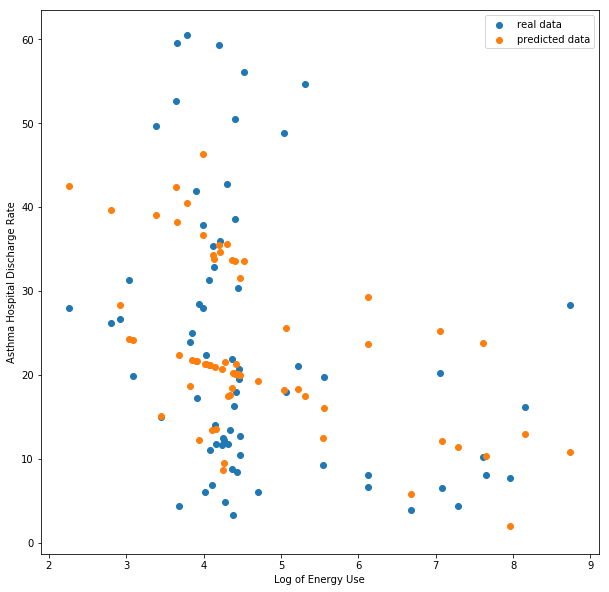

In [66]:
plt.figure(figsize = [10,10])
plt.scatter(np.log(data.Site_EUI),data.Discharge_Rate,label='real data')
plt.scatter(np.log(data.Site_EUI),model3.predict(),label='predicted data')
plt.xlabel('Log of Energy Use')
plt.ylabel('Asthma Hospital Discharge Rate')
plt.legend()
plt.show()

### Figure 1. Logarithm model of energy use and public health

In [67]:
energy_16 = pd.read_excel('http://www.nyc.gov/html/gbee/downloads/excel/nyc_benchmarking_disclosure_data_reported_in_2016.xlsx')

In [68]:
energy_16.rename(columns = {[x for x in energy_16 if 'Site EUI' in x][0]:'Site EUI',
                               'Property Floor Area (Buildngs and Parking)\n(ft2)':'Reported Building Square Footage',
                               [x for x in energy_16 if 'DOF Property Floor Area' in x][0]:'Reported Building Square Footage',
                              'Weather Normalized Source EUI\n(kBtu/ft2)':'Weather Normalized Source EUI',
                               'Zip Code':'Zip','DOF Number of Buildings':'Number of Buildings',
                              'Total GHG Emissions\n(MtCO2e)':'GHG',
                          'Primary Property Type - Self Selected':'Reported Facility Type'},inplace=True)
# select only residential buildings
energy_16 = energy_16[(energy_16['Reported Facility Type'] == 'Residence Hall/Dormitory')|(energy_16['Reported Facility Type'] == 'Multifamily Housing')|
           (energy_16['Reported Facility Type'] == 'Lodging')|(energy_16['Reported Facility Type'] == 'Other - Lodging/Residential')]
energy_16['Zip'] = energy_16['Zip'].astype('str')
energy_16['Zip'] = energy_16['Zip'].str[:5]
energy_16 = energy_16.groupby('Zip').sum()[['Site EUI']]
energy_16.dropna(axis=0,inplace=True)

In [69]:
energy_16 = energy_16[:-1]

In [70]:
energy_16 = clean(energy_16,'Site EUI')

In [71]:
energy_16.reset_index(inplace=True)

In [72]:
energy_16.describe()

,Site EUI
count,167.000000
mean,12961.024551
std,28009.591834
min,22.900000
25%,838.950000
50%,2544.600000
75%,9765.150000
max,162123.900000


In [73]:
data_new = data[['Zip_Code','demo1','demo2','demo3','demo4','demo5','demo6','demo7']]

In [74]:
data_new = data_new.merge(energy_16, left_on = 'Zip_Code',right_on='Zip')

In [75]:
data_new.rename(columns={'Site EUI':'Site_EUI'},inplace=True)

In [76]:
data_new['pred_discharge_rate'] = model3.predict(data_new)

In [77]:
data_new = data_new[['Zip','pred_discharge_rate']][data_new['pred_discharge_rate']>=0]

In [78]:
data_new.head()

,Zip,pred_discharge_rate
0,10001,21.038921
1,10002,5.374911
3,10009,14.561680
5,10011,19.330897
6,10012,8.593516


## So now we have the predicted 2016 asthma hospital discharge rate for some Zipcode areas

In [95]:
nyc = gpd.GeoDataFrame.from_file('ZIP_CODE_040114.shp')

In [96]:
nyc.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [97]:
nyc = nyc.merge(data_new,left_on='ZIPCODE',right_on='Zip',how='outer')

In [91]:
nyc.pred_discharge_rate = nyc.pred_discharge_rate.fillna(0)

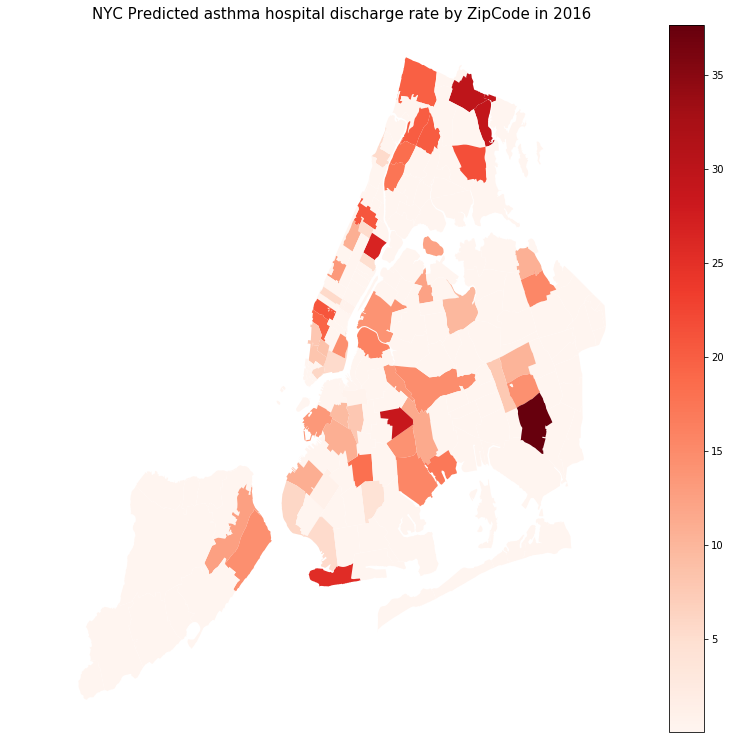

In [170]:
fig = plt.figure(figsize=[13,13])
ax = fig.add_subplot(111)
nyc.plot(column='pred_discharge_rate', cmap='Reds',ax=ax,legend=True,alpha=1)
ax.set_title('NYC Predicted asthma hospital discharge rate by ZipCode in 2016',size=15)
ax.set_axis_off()
ax.legend()

### Figure 3. NYC Predicted asthma hospital discharge rate by ZipCode in 2016